<a href="https://colab.research.google.com/github/heejipark/Research-PPG2ABP-using-GAN/blob/dev/02-Change_from_InstantNorm1d_to_BatchNorm1d.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Preprocessing

In [2]:
!pip install vitaldb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 4.5 MB/s 
     |████████████████████████████████| 140 kB 16.4 MB/s 
     |████████████████████████████████| 64 kB 4.1 MB/s 
     |████████████████████████████████| 1.1 MB 70.9 MB/s 
     |████████████████████████████████| 8.6 MB 80.2 MB/s 
     |████████████████████████████████| 271 kB 91.0 MB/s 
     |████████████████████████████████| 144 kB 95.8 MB/s 
     |████████████████████████████████| 94 kB 4.7 MB/s 
     |████████████████████████████████| 127 kB 93.7 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datascience 0.10.6 requires folium==0.2.1, but you 

In [3]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Check time
from tqdm import tqdm
from time import sleep

# Datasets
import vitaldb
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
from torch.optim import Adam
import torch.utils.data
from torch.utils.data import DataLoader, TensorDataset
import torchvision.datasets
import torchvision.utils as vutils
from torch.optim.lr_scheduler import LambdaLR
import torch.nn.functional as F

# For model
import argparse
import itertools

from tqdm import tqdm
import time

%matplotlib inline

cachefile = '/content/drive/MyDrive/snuh/ppg_abp_datasets_20_30ppl.npz'

# set the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
Tensor = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.Tensor

In [4]:
ppg_abp_sets = np.load(cachefile)       # Load cache file
ppg_sets = ppg_abp_sets['ppg_sets']
abp_sets = ppg_abp_sets['abp_sets']
ppg_abp_sets.close()                    # For memory efficiency, close the file

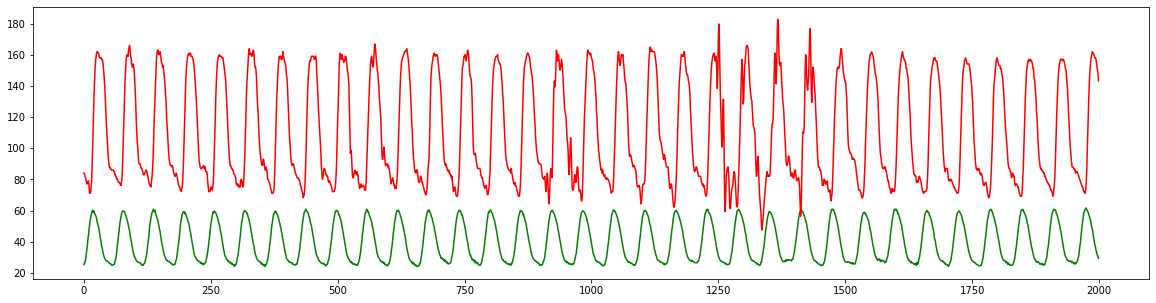

In [5]:
#### Before Preprocessing ------------------------------------
# Draw a sample waveform for PPG
plt.figure(figsize=(20,5))
plt.plot(ppg_sets[2], color='g', label='PPG')
plt.plot(abp_sets[2], color='r', label='ABP')

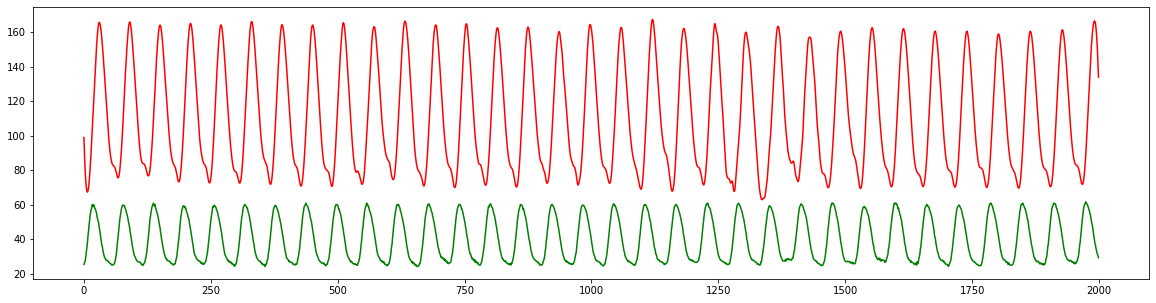

In [6]:
#### After Preprocessing ------------------------------------
from scipy.signal import savgol_filter
filtered_abp = savgol_filter(abp_sets, 31, 3)
plt.figure(figsize=(20,5))
plt.plot(ppg_sets[2], color='g', label='PPG')
plt.plot(filtered_abp[2], color='r', label='ABP')

In [7]:
# Shape of data ----------------------------
print(ppg_sets.shape)
print(filtered_abp.shape)

(11550, 2000)
(11550, 2000)


In [8]:
## Min-Max Normalization
max_ppg, min_ppg = np.max(ppg_sets), np.min(ppg_sets)
max_abp, min_abp = np.max(filtered_abp), np.min(filtered_abp)

norm_ppg_sets = ((ppg_sets - min_ppg) / (max_ppg - min_ppg))
norm_abp_sets = ((filtered_abp - min_abp) / (max_abp - min_abp))

## Hyperparameter

In [9]:
# Make a directory to save the model for further use
MODEL_ID = 'train'
MODEL_SAVE_PATH = "/outputs/" + MODEL_ID
if not os.path.exists(MODEL_SAVE_PATH):
    os.makedirs(MODEL_SAVE_PATH)
CHECKPOINT_DIR = os.path.join(MODEL_SAVE_PATH, 'training_checkpoints')

# Data path
epoch = 0            # starting epoch
n_epochs = 10        # number of epochs of training
batch_size = 64      # size of the batches
lr = 1e-4            # initial learning rate
decay_epoch = 100    # epoch to start linearly decaying the learning rate to 0
workers = 2          # number of workers
input_nc = 1         # number of channels of input data
output_nc = 1        # number of channels of output data
beta1 = 1            # beta1 value for Adam optimizer
seed = 30            # random seed


# LR schedulers
#lr_scheduler_G = optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
#lr_scheduler_D_P2A = optim.lr_scheduler.LambdaLR(optimizer_D_P2A, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)
#lr_scheduler_D_A2P = optim.lr_scheduler.LambdaLR(optimizer_D_A2P, lr_lambda=LambdaLR(n_epochs, epoch, decay_epoch).step)

# Model parameters
# It is for commend line
# parser = argparse.ArgumentParser()
# parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
# parser.add_argument('--n_epochs', type=int, default=10, help='number of epochs of training')
# parser.add_argument('--batch_size', type=int, default=64, help='size of the batches')
# parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
# parser.add_argument('--decay_epoch', type=int, default=100, help='epoch to start linearly decaying the learning rate to 0')
# parser.add_argument('--workers', type=int, default=2, help='the number of workers')
# parser.add_argument('--input_nc', type=int, default=1, help='number of channels of input data')
# parser.add_argument('--output_nc', type=int, default=1, help='number of channels of output data')
# parser.add_argument('--beta1', type=int, default=1, help='betal value for Adam optimizer')
# parser.add_argument('--seed', type=int, default=30, help='random seed')
# opt = parser.parse_args()
# print(opt)

## Dataloader

In [10]:
# Split data into training and testing datasets
ppg_train, ppg_test, abp_train, abp_test = train_test_split(norm_ppg_sets, norm_abp_sets, test_size=0.2, random_state=25)

# Change data type
ppg_train = torch.tensor(ppg_train, dtype=torch.float32)
ppg_test = torch.tensor(ppg_test, dtype=torch.float32)
abp_train = torch.tensor(abp_train, dtype=torch.float32)
abp_test = torch.tensor(abp_test, dtype=torch.float32)

# Make the datasets as a TensorDataset
ds_train = TensorDataset(ppg_train, abp_train)
ds_test = TensorDataset(ppg_test, abp_test)

# Create the dataloader
loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=False, num_workers=workers)
loader_test = DataLoader(ds_test, batch_size=batch_size, shuffle=False, num_workers=workers)

In [11]:
ppg_train.shape # (batch size, dim)

torch.Size([9240, 2000])

## Model

In [12]:
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        layer = [nn.ReflectionPad1d(1),
                 nn.Conv1d(in_features, in_features, 3),
                 nn.BatchNorm1d(in_features),
                 nn.ReLU(inplace=True),
                 nn.ReflectionPad1d(1),
                 nn.Conv1d(in_features, in_features, 3),
                 nn.BatchNorm1d(in_features)]
        
        self.conv_block = nn.Sequential(*layer)

    def forward(self, x):
        return x + self.conv_block(x)

1. Generator(Encoder)
    -> C64, C128, C256, C512, C512, C512, C512, C512
2. Generator(Decoder)
    -> CD512 - CD 
3. Discriminator
    -> C64 - C128 - C256 - C512 - C1

In [13]:
class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, n_residual_blocks=9):
        super(Generator, self).__init__()
    
        # Initial convolution block       
        self.model1 = nn.Sequential(
                 nn.ReflectionPad1d(1),
                 nn.Conv1d(input_nc, 64, 3),
                 #nn.InstanceNorm1d(64),
                 #nn.LeakyReLU(inplace=True)
                 )

        # Encoder - Downsampling
        in_features = 64
        out_features = in_features*2
        model2 = []
        for _ in range(2):
            model2 += [nn.Conv1d(in_features, out_features, 3, stride=2, padding=1),
                       nn.BatchNorm1d(out_features),
                       nn.LeakyReLU(0.2, inplace=True)]
            in_features = out_features
            out_features = in_features*2
        self.model2 = nn.Sequential(*model2)
        
        model3=[]
        # Residual blocks
        for _ in range(n_residual_blocks):
            model3 += [ResidualBlock(in_features)]
        self.model3 = nn.Sequential(*model3)
        
        # Decoder - Upsampling
        model4 = []
        out_features = in_features//2
        for _ in range(2):
            model4 += [nn.ConvTranspose1d(in_features, out_features, 3, stride=2, padding=1, output_padding=1),
                      nn.BatchNorm1d(out_features),
                      nn.LeakyReLU(0.2, inplace=True)]
            in_features = out_features
            out_features = in_features//2
        self.model4 = nn.Sequential(*model4)
        
        # Output layer
        self.model5 = nn.Sequential(
                  nn.ReflectionPad1d(1),
                  nn.Conv1d(64, output_nc, 3))

    def forward(self, x):
        x = self.model1(x) 
        x = self.model2(x)
        x = self.model3(x)
        x = self.model4(x)
        out = self.model5(x)
        return out

In [14]:
class Discriminator(nn.Module):
    def __init__(self, input_nc):
        super(Discriminator, self).__init__()

        # A bunch of convolutions one after another
        model = [nn.Conv1d(input_nc, 64, 1, stride=2, padding=1),
                 nn.LeakyReLU(0.2, inplace=True) ]

        model += [nn.Conv1d(64, 128, 1, stride=2, padding=1),
                  nn.BatchNorm1d(128), 
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv1d(128, 256, 1, stride=2, padding=1),
                  nn.BatchNorm1d(256), 
                  nn.LeakyReLU(0.2, inplace=True)]

        model += [nn.Conv1d(256, 512, 1, padding=1),
                  nn.BatchNorm1d(512), 
                  nn.LeakyReLU(0.2, inplace=True)]

        # FCN classification layer
        model += [nn.Conv1d(512, 1, 1, padding=1)]
        model += [nn.Tanh()]
        self.model = nn.Sequential(*model)

    def forward(self, x):
        #return self.model(x)
        # Average pooling and flatten
        return F.avg_pool1d(x, x.size()[2:]).view(x.size()[0], -1)

In [15]:
# Initalize Generator and Discriminator
netG_P2A = Generator(input_nc, output_nc).to(device)
netG_A2P = Generator(output_nc, input_nc).to(device)
netD_PPG = Discriminator(input_nc).to(device)
netD_ABP = Discriminator(input_nc).to(device)

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm1d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)


# need Weight Initialization
netG_P2A.apply(weights_init_normal)
netG_A2P.apply(weights_init_normal)
netD_PPG.apply(weights_init_normal)
netD_ABP.apply(weights_init_normal)

# Optimizers
optimizer_G = optim.Adam(itertools.chain(netG_P2A.parameters(), netG_A2P.parameters()), lr=lr, betas=(0.5, 0.999))
optimizer_D_PPG = optim.Adam(netD_ABP.parameters(), lr=lr, betas=(0.5, 0.999))
optimizer_D_ABP = optim.Adam(netD_PPG.parameters(), lr=lr, betas=(0.5, 0.999))

# Cross-function
criterion_gan = nn.MSELoss().to(device)      # How the discriminator discriminates the data whether it is generated or not
criterion_identity = nn.L1Loss().to(device)  # How different the generated data is from the original data through forward OR backward transformations
criterion_cycle = nn.L1Loss().to(device)     # How different the generated data is from the original data through forward AND backward transformations

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  del sys.path[0]


In [16]:
print(netG_P2A)
print(netD_PPG)

Generator(
  (model1): Sequential(
    (0): ReflectionPad1d((1, 1))
    (1): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  )
  (model2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(3,), stride=(2,), padding=(1,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): Conv1d(128, 256, kernel_size=(3,), stride=(2,), padding=(1,))
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (model3): Sequential(
    (0): ResidualBlock(
      (conv_block): Sequential(
        (0): ReflectionPad1d((1, 1))
        (1): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
        (2): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU(inplace=True)
        (4): ReflectionPad1d((1, 1))
        (5): Conv1d(256, 256, kernel_size=(3,), stride=(1,))
        (6): Batc

## Train

In [17]:
for epoch in range(epoch, n_epochs):
    print("%d epoch-------------------------------"%(epoch+1))
    for real_ppg, real_abp in tqdm(loader_train):
        time.sleep(0.01)
        #########################################
        # Generator PPG2ABP and ABP2PPG
        # 1. GAN loss
        # 2. Cycle loss
        # 3. Identity loss
        # 4. Total loss
        #########################################
        
        # Forward------------------------------------------
        # Transform the datasets
        real_ppg_3d = real_ppg.unsqueeze(0).transpose(0,1).to(device)
        real_abp_3d = real_abp.unsqueeze(0).transpose(0,1).to(device)
        
        # 1. Generate fake data
        fake_abp = netG_P2A(real_ppg_3d)
        fake_ppg = netG_A2P(real_abp_3d)

        recovered_ppg = netG_A2P(fake_abp)
        recovered_abp = netG_P2A(fake_ppg)
        
        identity_abp = netG_P2A(real_abp_3d)
        identity_ppg = netG_A2P(real_ppg_3d)
        
        
        # Backward generator path --------------------------
        discFakeppg = netD_PPG(fake_ppg)
        discFakeabp = netD_ABP(fake_abp)
        discCycleppg = netD_PPG(recovered_ppg)
        discCycleabp = netD_ABP(recovered_abp)
        
        
        # 1. GAN loss
        loss_ppg = criterion_gan(discFakeppg, torch.ones_like(discFakeppg))
        loss_abp = criterion_gan(discFakeabp, torch.ones_like(discFakeabp))
        
        
        # 2. Cycle loss
        loss_cycle_abp = criterion_cycle(recovered_abp, real_abp_3d)
        loss_cycle_ppg = criterion_cycle(recovered_ppg, real_ppg_3d)
        
        # 3. Identity loss
        loss_identity_ppg = criterion_identity(identity_ppg, real_ppg_3d)
        loss_identity_abp = criterion_identity(identity_abp, real_abp_3d)
        
        
        # 4. Total loss = GAN loss + Cycle loss + Identity loss
        loss_G = (loss_ppg + loss_abp) + \
                 (loss_identity_ppg + loss_identity_abp) * 5.0 + \
                 (loss_cycle_ppg + loss_cycle_abp) * 10.0
        
        optimizer_G.zero_grad()
        loss_G.backward()   # Calculates the loss of the loss function
        optimizer_G.step()
        
        
        # Backward generator path --------------------------
        
        discFakeppg = netD_PPG(fake_ppg.detach())
        discRealppg = netD_PPG(real_ppg_3d)
        
        loss_D_Real_ppg = criterion_gan(discFakeppg, torch.ones_like(discFakeppg))
        loss_D_Fake_ppg = criterion_gan(discRealppg, torch.zeros_like(discRealppg))
                        
        loss_D_PPG = (loss_D_Real_ppg + loss_D_Fake_ppg) * 0.5
        optimizer_D_PPG.zero_grad()
        loss_D_PPG.requires_grad_(True)
        loss_D_PPG.backward()
        optimizer_D_PPG.step()
        
        discFakeabp = netD_ABP(fake_abp.detach())
        discRealabp = netD_ABP(real_abp_3d)
        
        loss_D_Real_abp = criterion_gan(discFakeabp, torch.ones_like(discFakeabp))
        loss_D_Fake_abp = criterion_gan(discRealabp, torch.zeros_like(discRealabp))
        
        loss_D_ABP = (loss_D_Real_abp + loss_D_Fake_abp) * 0.5
        optimizer_D_ABP.zero_grad()
        loss_D_ABP.requires_grad_(True)
        loss_D_ABP.backward()
        optimizer_D_ABP.step()
      
    print(loss_G, loss_D_ABP)
        
    # Update learning rate

1 epoch-------------------------------


100%|██████████| 145/145 [02:18<00:00,  1.05it/s]


tensor(1.3180, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2900, device='cuda:0', requires_grad=True)
2 epoch-------------------------------


100%|██████████| 145/145 [02:18<00:00,  1.05it/s]


tensor(1.1902, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2801, device='cuda:0', requires_grad=True)
3 epoch-------------------------------


100%|██████████| 145/145 [02:18<00:00,  1.05it/s]


tensor(1.0657, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2558, device='cuda:0', requires_grad=True)
4 epoch-------------------------------


100%|██████████| 145/145 [02:18<00:00,  1.05it/s]


tensor(0.9608, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2016, device='cuda:0', requires_grad=True)
5 epoch-------------------------------


100%|██████████| 145/145 [02:17<00:00,  1.05it/s]


tensor(0.8418, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1477, device='cuda:0', requires_grad=True)
6 epoch-------------------------------


100%|██████████| 145/145 [02:17<00:00,  1.05it/s]


tensor(1.1954, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.2775, device='cuda:0', requires_grad=True)
7 epoch-------------------------------


100%|██████████| 145/145 [02:17<00:00,  1.05it/s]


tensor(0.8109, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.1100, device='cuda:0', requires_grad=True)
8 epoch-------------------------------


100%|██████████| 145/145 [02:17<00:00,  1.05it/s]


tensor(0.7678, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0791, device='cuda:0', requires_grad=True)
9 epoch-------------------------------


100%|██████████| 145/145 [02:17<00:00,  1.05it/s]


tensor(0.6943, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0599, device='cuda:0', requires_grad=True)
10 epoch-------------------------------


100%|██████████| 145/145 [02:17<00:00,  1.05it/s]

tensor(0.5703, device='cuda:0', grad_fn=<AddBackward0>) tensor(0.0494, device='cuda:0', requires_grad=True)


In [18]:
print(recovered_abp.shape, real_abp_3d.shape)
print(recovered_ppg.shape, real_ppg_3d.shape)

torch.Size([24, 1, 2000]) torch.Size([24, 1, 2000])
torch.Size([24, 1, 2000]) torch.Size([24, 1, 2000])


## Test

In [19]:
###### Test ######

# Create output dirs if they don't exist
dataNum = 1
for real_ppg, real_abp in loader_test:
    # Set model input
    real_ppg_3d = real_ppg.unsqueeze(0).transpose(0,1).to(device)
    real_abp_3d = real_abp.unsqueeze(0).transpose(0,1).to(device)

    # Generate output
    fake_abp = netG_P2A(real_ppg_3d).data
    fake_ppg = netG_A2P(real_abp_3d).data
    
    revert_real_abp = real_abp_3d * (max_abp - min_abp) + min_abp
    revert_real_ppg = real_ppg_3d * (max_ppg - min_ppg) + min_ppg
    revert_fake_abp = fake_abp * (max_abp - min_abp) + min_abp
    revert_fake_ppg = fake_ppg * (max_ppg - min_ppg) + min_ppg

    # Save data file 
    resultfile ='/content/drive/MyDrive/snuh/output/BatchNorm1d/dataNum%d-shuffleFalse.npz'%(dataNum)
    np.savez(resultfile, real_abp=revert_real_abp.squeeze().cpu(), fake_abp=revert_fake_abp.squeeze().cpu(), 
             real_ppg=revert_real_ppg.squeeze().cpu(), fake_ppg=revert_fake_ppg.squeeze().cpu()) # Save cahce file
    dataNum += 1

## Draw a graph

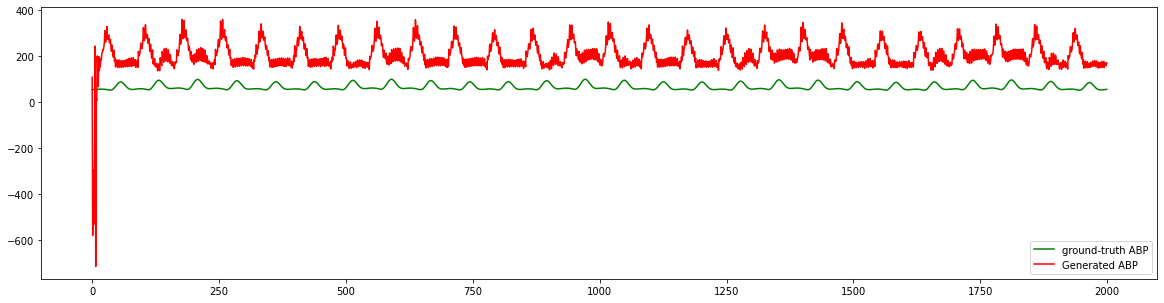

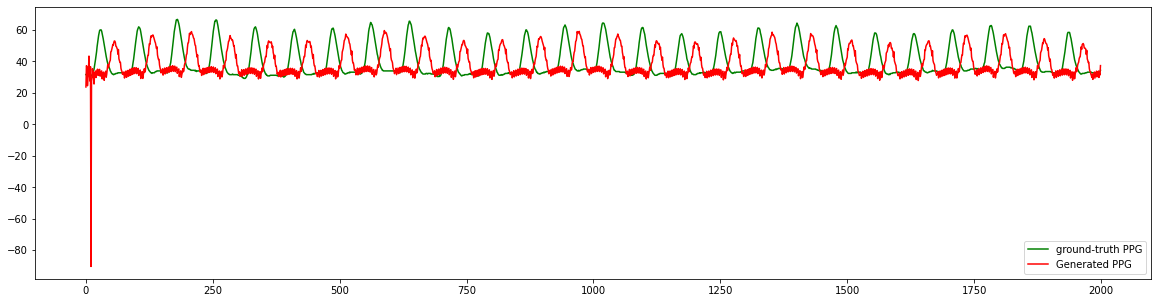

In [20]:
result = np.load('/content/drive/MyDrive/snuh/output/BatchNorm1d/dataNum1-shuffleFalse.npz')
real_abp_sets = result['real_abp']
real_ppg_sets = result['real_ppg']

fake_abp_sets = result['fake_abp']
fake_ppg_sets = result['fake_ppg']

plt.figure(figsize=(20,5))
plt.plot(real_abp_sets[0], color='g', label='ground-truth ABP')
plt.plot(fake_abp_sets[0], color='r', label='Generated ABP')
plt.legend()


plt.figure(figsize=(20,5))
plt.plot(real_ppg_sets[0], color='g', label='ground-truth PPG')
plt.plot(fake_ppg_sets[0], color='r', label='Generated PPG')
plt.legend()

plt.savefig('/content/drive/MyDrive/snuh/output/BatchNorm1d/realVSfake-dataNum1.png')

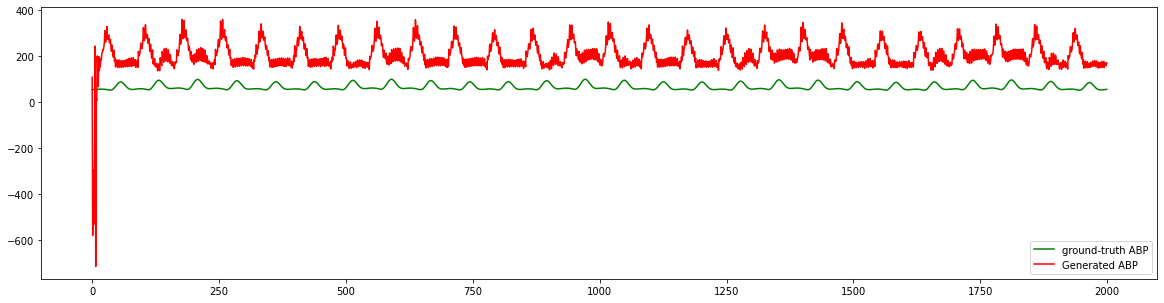

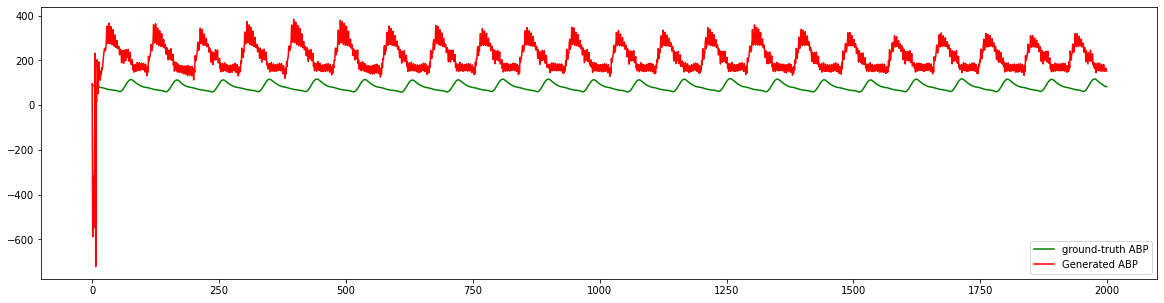

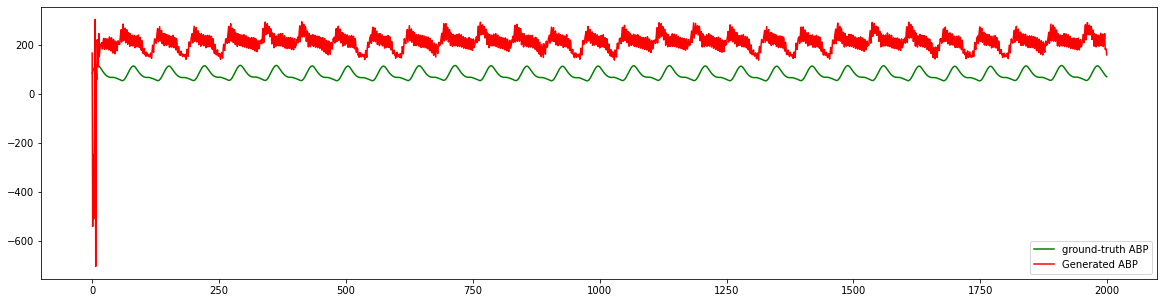

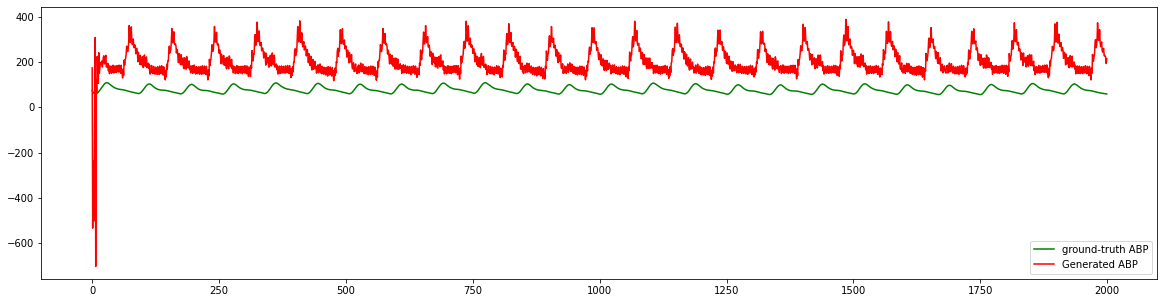

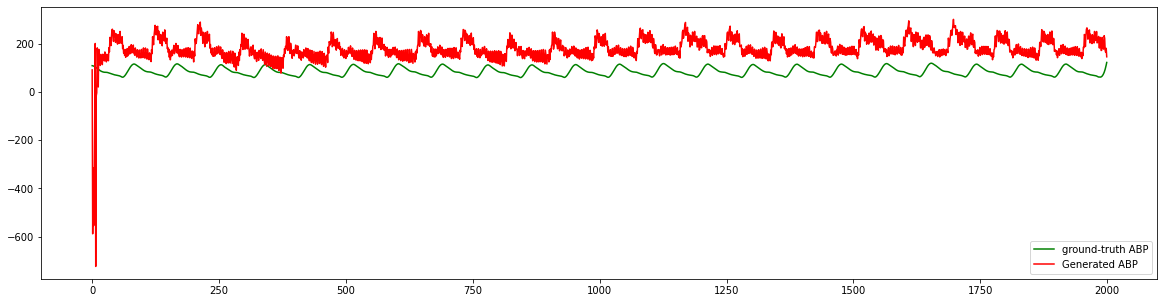

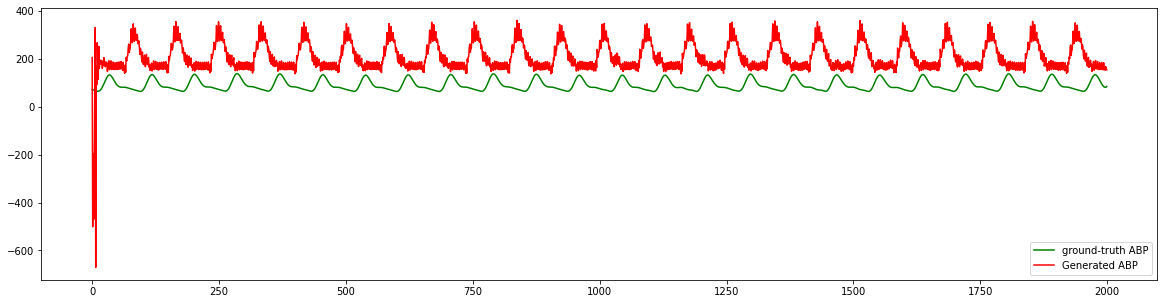

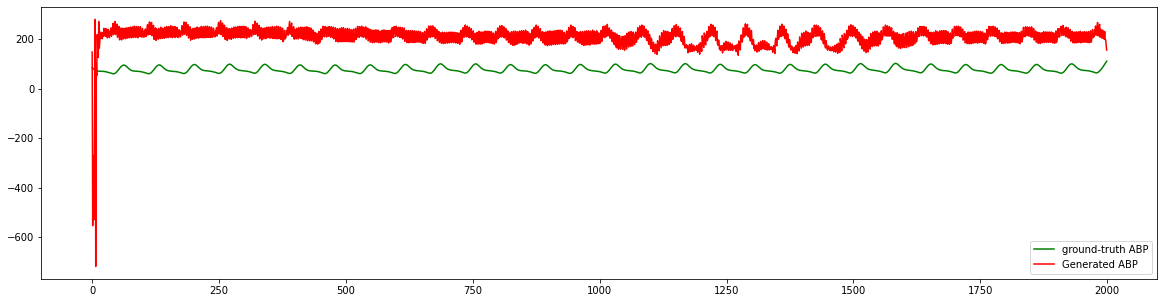

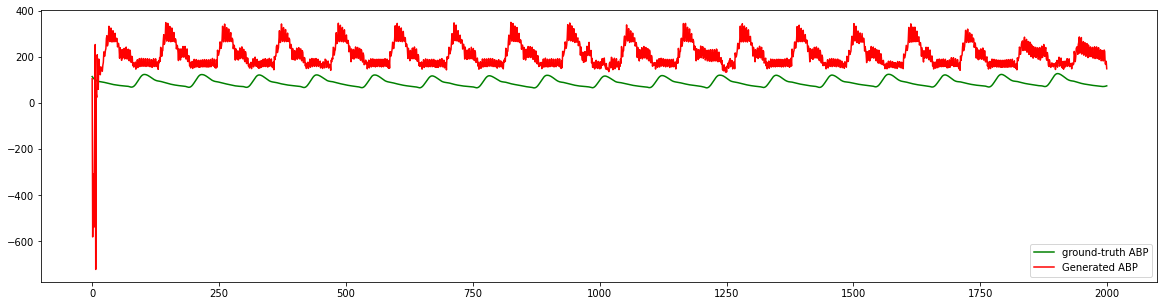

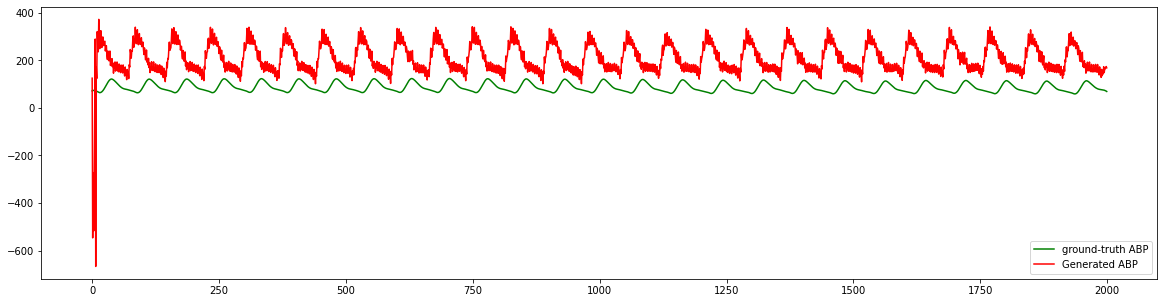

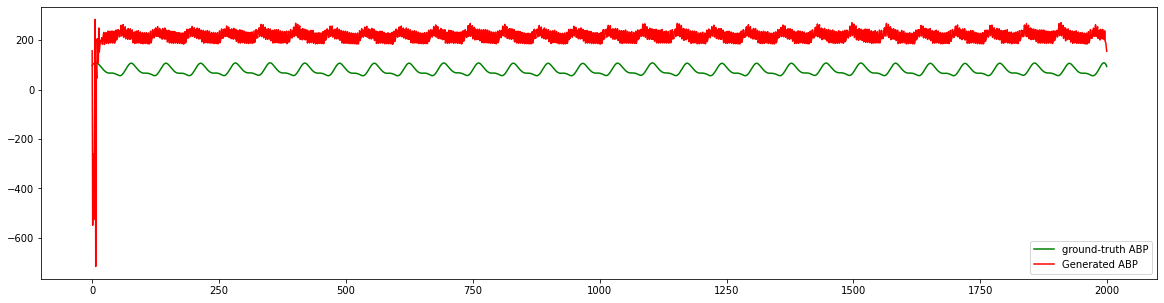

<Figure size 432x288 with 0 Axes>

In [21]:
for i in range(0,10):
  plt.figure(figsize=(20,5))
  plt.plot(real_abp_sets[i], color='g', label='ground-truth ABP')
  plt.plot(fake_abp_sets[i], color='r', label='Generated ABP')
  plt.legend()
  plt.show()


plt.savefig('/content/drive/MyDrive/snuh/output/BatchNorm1d/realVSfake-dataNum1-10_onlyABP.png')

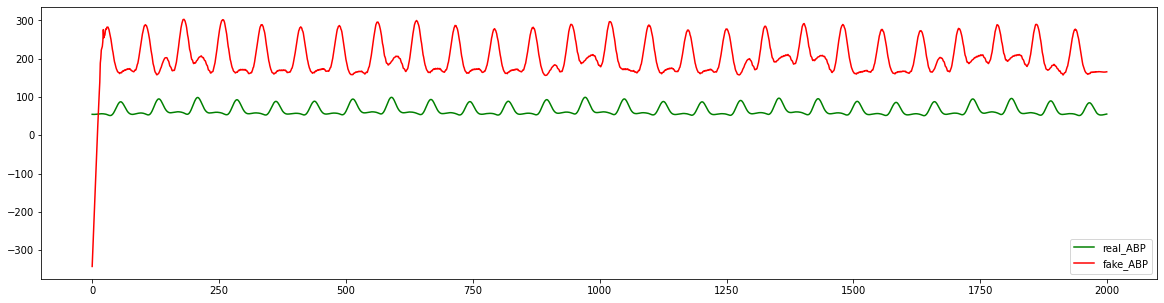

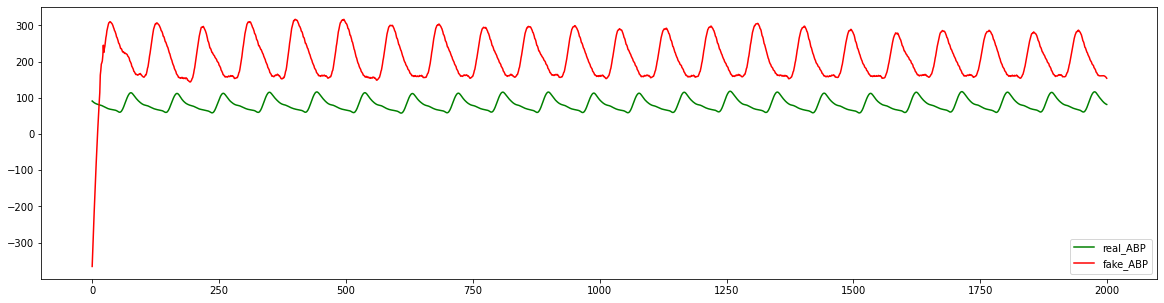

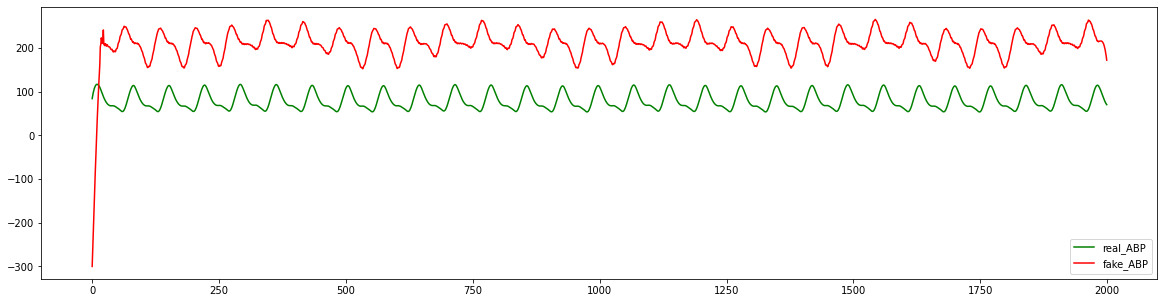

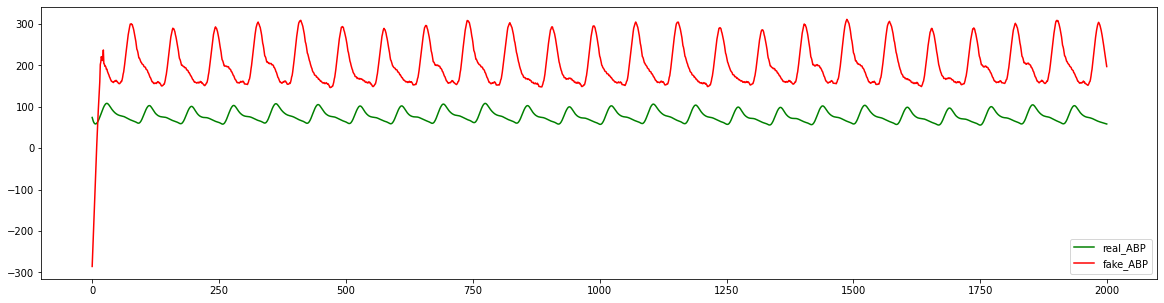

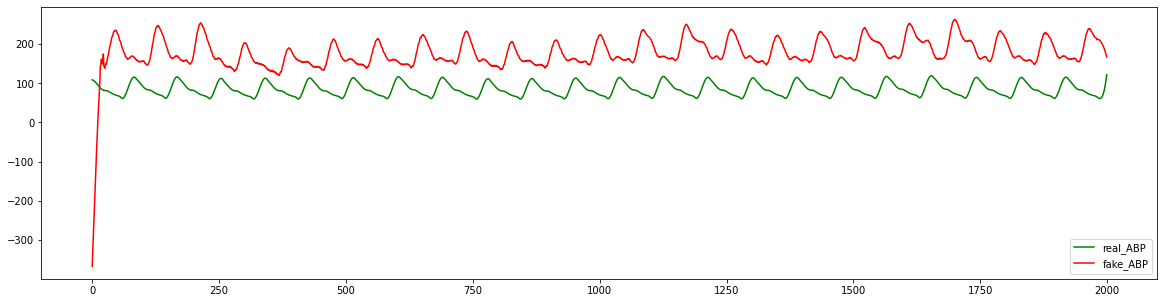

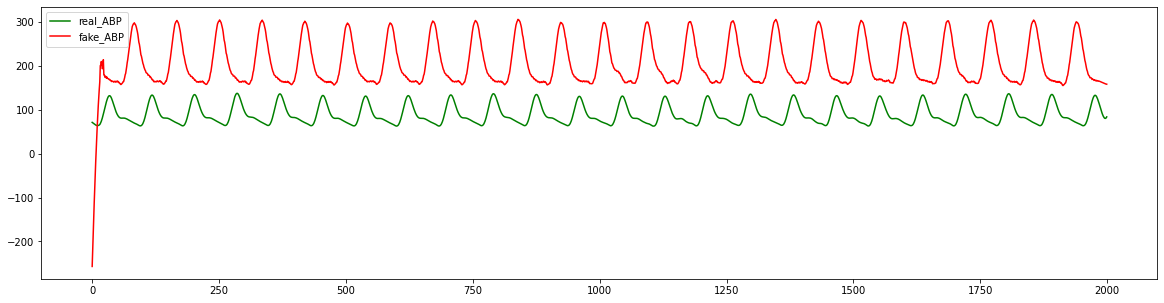

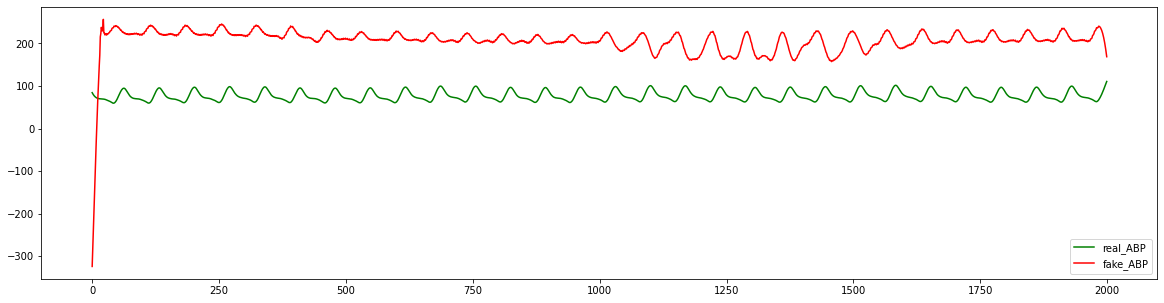

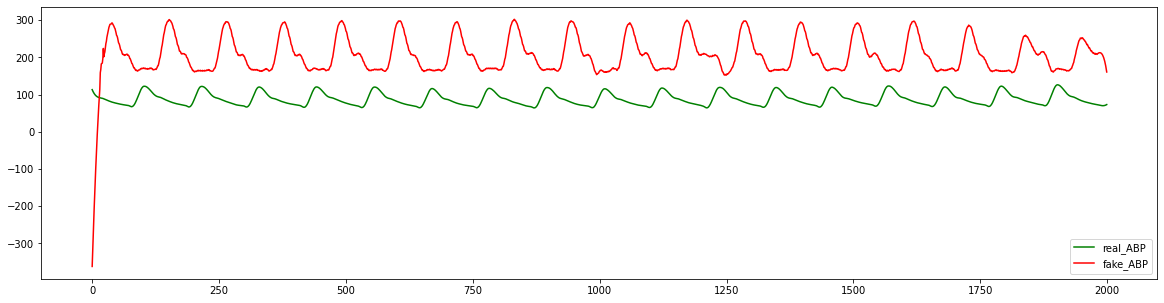

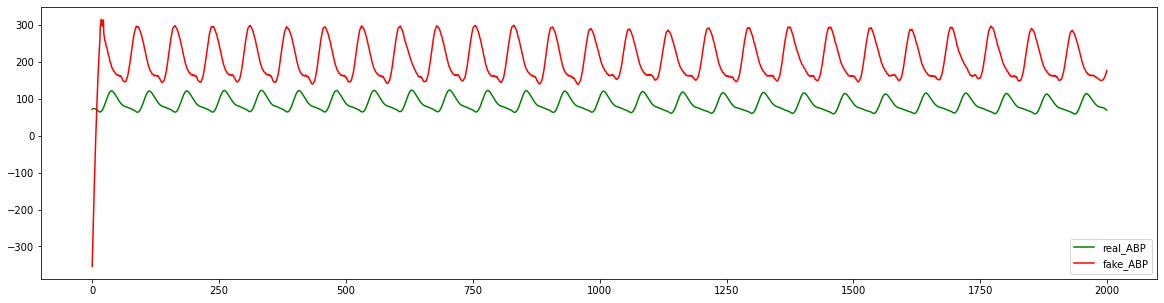

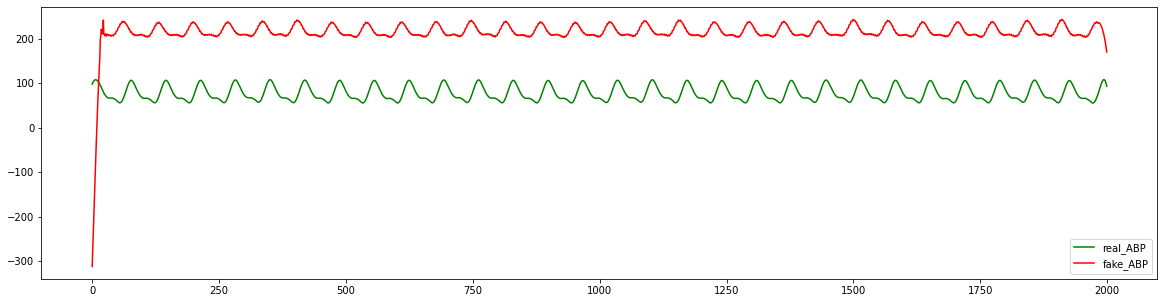

<Figure size 432x288 with 0 Axes>

In [22]:
from scipy.signal import savgol_filter
fake_filtered_abp = savgol_filter(fake_abp_sets, 31, 3)

for i in range(10):
  plt.figure(figsize=(20,5))
  plt.plot(real_abp_sets[i], color='g', label='real_ABP')
  plt.plot(fake_filtered_abp[i], color='r', label='fake_ABP')
  plt.legend()
  plt.show()

plt.savefig('/content/drive/MyDrive/snuh/output/BatchNorm1d/realVSfake-dataNum1-10_onlyABP_after_filter.png')

## Reference

- https://github.com/aitorzip/PyTorch-CycleGAN
- https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/train
- https://medium.com/humanscape-tech/ml-practice-cyclegan-f9153ef72297    
- https://github.com/heejipark/Research-PPG2ABP-using-GAN/blob/master/paper-review/PPG2ECG_CardioGAN.md
- https://github.com/heejipark/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/cyclegan/cyclegan.py
- https://www.slideshare.net/WuhyunRicoShin/tutorial-image-generation-and-imagetoimage-translation-using-gan
- https://github.com/heejipark/PyTorch-GAN/blob/36d3c77e5ff20ebe0aeefd322326a134a279b93e/implementations/cyclegan/models.py#L22
- https://medium.com/humanscape-tech/ml-practice-cyclegan-f9153ef72297
- https://github.com/aitorzip/PyTorch-CycleGAN/blob/master/train

## nn.Conv()

#### Conv1d — Input 1d
<pre>
nn.Conv1d() applies 1D convolution over the input. nn.Conv1d() expects the input to be of the shape [batch_size, input_channels, signal_length] .

You can check out the complete list of parameters in the official PyTorch Docs. The required parameters are —

in_channels (python:int) — Number of channels in the input signal. This should be equal to the number of channels in the input tensor.
out_channels (python:int) — Number of channels produced by the convolution.
kernel_size (python:int or tuple) — Size of the convolving kernel.
</pre>
<code>
  input_1d = tensor([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]) = torch.Size([10])
  input_2d = tensor([[ 1.,  2.,  3.,  4.,  5.], [ 6.,  7.,  8.,  9., 10.]]) = torch.Size([2, 5])
  
  input_1d = input_1d.unsqueeze(0).unsqueeze(0) # in order to insert CNN, change the format
  input_2d = input_2d.unsqueeze(0)
</code>


#### Conv1d — Input 2d
<pre>
To apply 1D convolution on a 2d input signal, we can do the following. First, we define our input tensor of the size [1, 2, 5] where batch_size = 1,

</pre>


#### Conv2d - Input 3d
nn.Conv2d() applies 2D convolution over the input. nn.Conv2d() expects the input to be of the shape [batch_size, input_channels, input_height,






reference: https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-cnn-26a14c2ea29